# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
\end{pmatrix}
$$

$$
b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}
$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [10]:
#--------------------------------------------------------------------
#Here we construct several key elements of the program such as classes as weel as the two functions that handle the boundary conditions and the main tri-diagonal   (this is done with sparse matrices to save memory and computational power - no need to compute all those zeroes!)
#--------------------------------------------------------------------
from scipy import sparse
import scipy
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

class Metal:
    def __init__(self, llambda: float, rho: float, C: float, L: float):
        self.llambda = llambda
        self.rho = rho
        self.C = C
        self.L = L

    def thermaldiff(self):
        return self.llambda / (self.rho * self.C)
    
Iron = Metal(llambda = 59, rho = 7900, C = 450, L = 0.5)

print("Thermal Diffusivity of our Iron rod:",Iron.thermaldiff())

class FiniteDifference:
    def __init__(self, N: int, t, x, d_0: float, d_N: float, bc: str):
        self.N = N  #Dimension of matrix
        self.t = t  #temporal points
        self.x = x  #spatial points
        self.d_0 = d_0 #temperature at intial space point (x = 0.0)
        self.d_N = d_N  #temperature at final space point (x = 0.5)
        self.bc = bc #boundary condition statement

    def tau(self, t):
        return t[1] - t[0]

    def h(self, x):
        return x[1] - x[0]

    def alpha(self, Metal):
        k = Metal.thermaldiff()
        return (k *  self.tau(self.t)) / (self.h(self.x))**2
    
    def tridiag(self, Metal, lower, main, upper):
        N = self.N 
        # if self.bc == 'testdirichlet':
        #     k = 1 
        #     a = 1
        #     return sparse.diags([-1 * a, (1 + 2*  a), -1 * a], [-1, 0, 1], shape = ((N-2, N-2))).toarray()       
        a = self.alpha(Metal)
        M = sparse.diags([lower * np.ones(N-3), main * np.ones(N-2), upper * np.ones(N-3)], [-1, 0, 1], shape = ((N-2, N-2)), format = 'csr')
        # M = sparse.diags([-1 * a, (1 + 2*  a), -1 * a], [-1, 0, 1], shape = ((N-2, N-2)), format = 'csr')
        if self.bc == 'dirichlet':
            pass
        elif self.bc == 'neumann':
            M[-1, -1] = 1 + a
        return M

    def BoundaryCondition(self, Metal) -> np.ndarray:
        a = self.alpha(Metal); N = self.N
        if self.bc =='dirichlet':
            B = np.zeros(N-2)
            B[0] = -a * self.d_0
            B[-1] = -a * self.d_N
            return B
        elif self.bc == 'neumann':
            B = np.zeros(N-2)
            B[0] = -a * self.d_0
            return B
        
        

times = np.linspace (0, 8, 9)
points = np.linspace(0, 8, 5)
TestMetal = Metal(llambda = 1, rho = 1, C = 1, L = 0.5)
TestDirichlet = FiniteDifference(7, times, points, 1000, 0, 'dirichlet')

# print('\n')
# print("Our test value for alpha:", TestDirichlet.alpha(TestMetal))
# print('\n')
# print("Our Test Matrix with Dirichlet BC's:", "\n",TestDirichlet.tridiag(TestMetal).toarray())
# print('\n')
# print("Our Test Matrix with Nuemann BC's:", "\n",TestNeumann.tridiag(TestMetal).toarray())
# print('\n')
# print("Our Boundary Condition term for Dirichlet BC's :", TestDirichlet.BoundaryCondition(TestMetal))
# print('\n')


# "All test results look correct from expected forms. Note i used .toarray() here to simply show the matrices in a nicer form than how sparse matrices usually look, i do not use .toarray() in calculations as to save computational power and time - it's more efficient to not calculate all those zeros. "




Thermal Diffusivity of our Iron rod: 1.659634317862166e-05


Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [11]:
#--------------------------------------------------------------------
#Now we go on to implement the implicit finite difference scheme to transport our temperature distribution along the rod to the next time step using .spsolve
#--------------------------------------------------------------------
def transport(FiniteDifference, u, Metal, scheme:str):
    """
    Transports the temperature distribution at a time step n to time step n+1. I rearrange the matrix equation here.
    """
    a = FiniteDifference.alpha(Metal)
    if scheme == 'implicit':
         lower = -a
         main = (1 + 2 * a)
         upper = -a
         B = u - FiniteDifference.BoundaryCondition(Metal)
    elif scheme == 'crank':
         lower = - a / 2
         main = 1 + a 
         upper = -a / 2
         main2 = 1 - a
         B = FiniteDifference.tridiag(Metal, -lower, main2, -upper) * u - FiniteDifference.BoundaryCondition(Metal)
     #not sure if using operations when passing variables here affects performance, but should be ok.
    A = FiniteDifference.tridiag(Metal, lower, main, upper)

    u_n1 = spsolve(A, B)
    return u_n1


Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

[1000.          989.84588623  979.69182593  969.53787253  959.38407931
  949.23049945  939.07718586  928.92419122  918.77156786  908.61936776
  898.46764247  888.31644304  878.16582002  868.01582336  857.86650238
  847.71790574  837.57008134  827.42307632  817.276937    807.13170883
  796.98743631  786.84416302  776.70193151  766.56078328  756.42075875
  746.28189722  736.14423678  726.00781434  715.87266556  705.73882482
  695.60632517  685.47519832  675.3454746   665.21718291  655.09035073
  644.96500406  634.8411674   624.71886374  614.59811452  604.47893961
  594.3613573   584.24538429  574.13103563  564.01832476  553.90726346
  543.79786185  533.69012838  523.58406982  513.47969125  503.37699607
  493.27598597  483.17666095  473.07901932  462.98305768  452.88877095
  442.79615236  432.70519346  422.61588413  412.52821259  402.4421654
  392.35772751  382.27488222  372.19361124  362.1138947   352.03571116
  341.95903763  331.88384961  321.8101211   311.73782462  301.66693127
  291.5

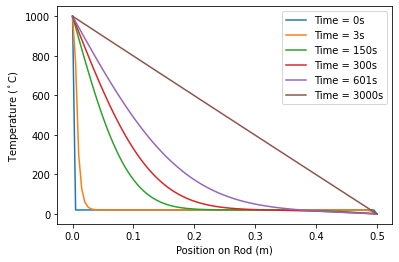

In [14]:
#--------------------------------------------------------------------
#Finally, we implement a simple loop to calculate the temperature distribution for all the time steps, and then plot using matplotlib.
#--------------------------------------------------------------------
def time_temp(FiniteDifference, T, scheme):
    grid = np.full((T, FiniteDifference.N), 20.0) # size T x 200
    grid[:, 0] = FiniteDifference.d_0
    u = np.full(FiniteDifference.N-2, 20.00)
    internal = grid[:, 1:FiniteDifference.N-1] 
    if FiniteDifference.bc == 'dirichlet':
        grid[:, -1] = FiniteDifference.d_N
        for k in range(1, T):
            internal[k, ] = transport(FiniteDifference, u, Iron, scheme)
            u[:] = internal[k, ]
    elif FiniteDifference.bc == 'neumann':
        for k in range(1, T):
            internal[k, ] = transport(FiniteDifference, u, Iron, scheme)
            # internal[:, -1] = internal[:, -2]
            grid[:, -1] = grid[:, -2]
            u[:] = internal[k, ]
    return grid

Time = 3000
numpoints = 100
timepoints = 1000
ts = np.linspace(0, Time, timepoints)
# ts = np.arange(0, T, 100)
xs = np.linspace(0, Iron.L, numpoints)

Dirichlet = FiniteDifference(numpoints, ts, xs, 1000, 0, 'dirichlet')
# print(time_temp(Dirichlet, Time)[-1])


# intensity = np.transpose(time_temp(Implicit, T))

def timeplots(k:int, FiniteDifference, T):
    timelabel = "%.0f"%ts[k]
    plt.ylabel('Temperature ($^\circ$C)')
    plt.xlabel('Position on Rod (m)')
    plt.plot(xs, time_temp(FiniteDifference, T)[k,:], label = f'Time = {timelabel}s')
    plt.legend()
# for i in range(0, -1, 10):
#     timeplots([i], Dirichlet, Time)
timeplots(0, Dirichlet, Time)
timeplots(1, Dirichlet, Time)
timeplots(50, Dirichlet, Time)
timeplots(100, Dirichlet, Time)
timeplots(200, Dirichlet, Time)
# timeplots(300, Dirichlet, Time)
# timeplots(400, Dirichlet, Time)
timeplots(-1, Dirichlet, Time)




## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two nodes have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}
$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

In [13]:
TestNeumann = FiniteDifference(7, times, points, 1000, 20, 'neumann')

print("Our Boundary Condition term for Neumann BC's :", TestNeumann.BoundaryCondition(TestMetal))
print('\n', "Our Test Matrix for the Neumann Boundary conditions:", "\n",TestNeumann.tridiag(TestMetal).toarray())



Newtimes = 10000
New_t = np.linspace(0, Newtimes, timepoints)
Neumann = FiniteDifference(numpoints, New_t, xs, 1000, 20, 'neumann')




Our Boundary Condition term for Neumann BC's : [-250.    0.    0.    0.    0.]


TypeError: tridiag() missing 3 required positional arguments: 'lower', 'main', and 'upper'

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

In [ ]:

# print(time_temp(Neumann, Time))
timeplots(0, Neumann, Newtimes)
timeplots(250, Neumann, Newtimes)
timeplots(200, Neumann, Newtimes)
timeplots(999, Neumann, Newtimes)
# timeplos(2, Neumann, Time)
# timeplots(-1,  Neumann, Time)


In [ ]:
###Crank - Nicholson



# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.